check this 
https://github.com/auspatious/dea-coastlines/blob/5fb20451cf6cba151d656a8d213b1a5a04f16ad3/coastlines/combined.py#L105

In [1]:
# %% All the loads, farm input, datetime,

import os
import boto3
import rasterio as rio
from pystac_client import Client
import xarray as xr
import numpy as np
from pathlib import Path
import geopandas as gpd
from datetime import date, datetime

from stackstac import stack
import pystac
import rioxarray

from utils import *
import matplotlib.pyplot as plt

# Set environment and create AWS Session
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
os.environ['AWS_REQUEST_PAYER'] = 'requester'

print("Creating AWS Session")
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)
print(aws_session)

# open Farm
farm = gpd.read_file(farm_file, layer='AREA_IMOVEL_1')
bbox = get_bbox(farm)

#  Satellite imagery query params
today = date.today()
datetime_rangefull = str(f"2023-06-20/{str(today)}") #break  2017
max_cloud = 100
#bucketname = 'sanca'
satellite = 'Landsat'

/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f3/
Creating AWS Session


In [15]:
# %% GET COLLECTION AND PARAMETERS

farm_file = '/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/CAR.gpkg'
folder_nc = farm_file.split('CAR.gpkg')[0] + f'nc/{run}/'
print(folder_nc)

farm = gpd.read_file(farm_file, layer = 'AREA_IMOVEL_1')
bbox = get_bbox(farm)

/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f3/


In [18]:
# Usando todos Landsats

# Satellite imagery query params
today = date.today()
datetime_range = str(f"2012-06-20/2015-06-20") # {str(today)} #break  2017
max_cloud = 100
#bucketname = 'sanca'
satellite = 'Landsat'
URL = 'https://landsatlook.usgs.gov/stac-server'
cat = Client.open(URL)
collection_id = 'landsat-c2l2-st' # thermal 'landsat-c2l2-st' optical 'landsat-c2l2-sr'
collection = cat.get_collection(collection_id)
print(collection)

query_params = {
        "eo:cloud_cover": {"lt": max_cloud},
        "platform": {"in": ["LANDSAT_5","LANDSAT_7","LANDSAT_8", "LANDSAT_9"]},
       "landsat:collection_category": { "in": ['T1']}
        }

<CollectionClient id=landsat-c2l2-st>


### the search and items

In [19]:
search = cat.search(
    collections = [collection_id],
    bbox = bbox,
    datetime = datetime_range,
    query = query_params,
)
print(f"{search.matched()} items found \n ---")
# prepare items collection
items_dict = search.item_collection_as_dict()['features']


100 items found 
 ---


In [119]:
items = search.item_collection()
items[0]


<Item id=LC08_L2SP_219075_20150619_20200909_02_T1_ST>

In [ ]:
 # update URLs to use s3
for item in items_dict:
    for a in item['assets']:
        if 'alternate' in item['assets'][a] and 's3' in item['assets'][a]['alternate']:
            item['assets'][a]['href'] = item['assets'][a]['alternate']['s3']['href']
        item['assets'][a]['href'] = item['assets'][a]['href'].replace('usgs-landsat-ard', 'usgs-landsat')

item_collection = pystac.ItemCollection(items_dict)

# LOAD
with rio.Env(session = aws_session, AWS_S3_ENDPOINT= 's3.us-west-2.amazonaws.com'):
    dc = stack(item_collection,
                    #assets= assets,
                    chunksize = 256,
                    bounds_latlon = bbox,
                    epsg = 4326,
                    rescale=False, 
                    fill_value=0, 
                    dtype="uint16",
                    )
    
ds_ = dc.to_dataset( dim = 'band' ).persist()


### Trip moment on cloud_mask stuff from DEA

In [114]:
# WORKING PROJECT DEA
# https://github.com/auspatious/dea-coastlines/blob/5fb20451cf6cba151d656a8d213b1a5a04f16ad3/coastlines/combined.py#L212
nodata_mask = (ds['T'] == 0) 
mask_bitfields = [3, 4]  # cloud, cloud shadow
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

cloud_mask = ds["qa_pixel"].astype(int) & bitmask != 0

In [120]:
from odc.algo import mask_cleanup
dilated_cloud_mask = mask_cleanup(cloud_mask, [("opening", 5), ("dilation", 6)])

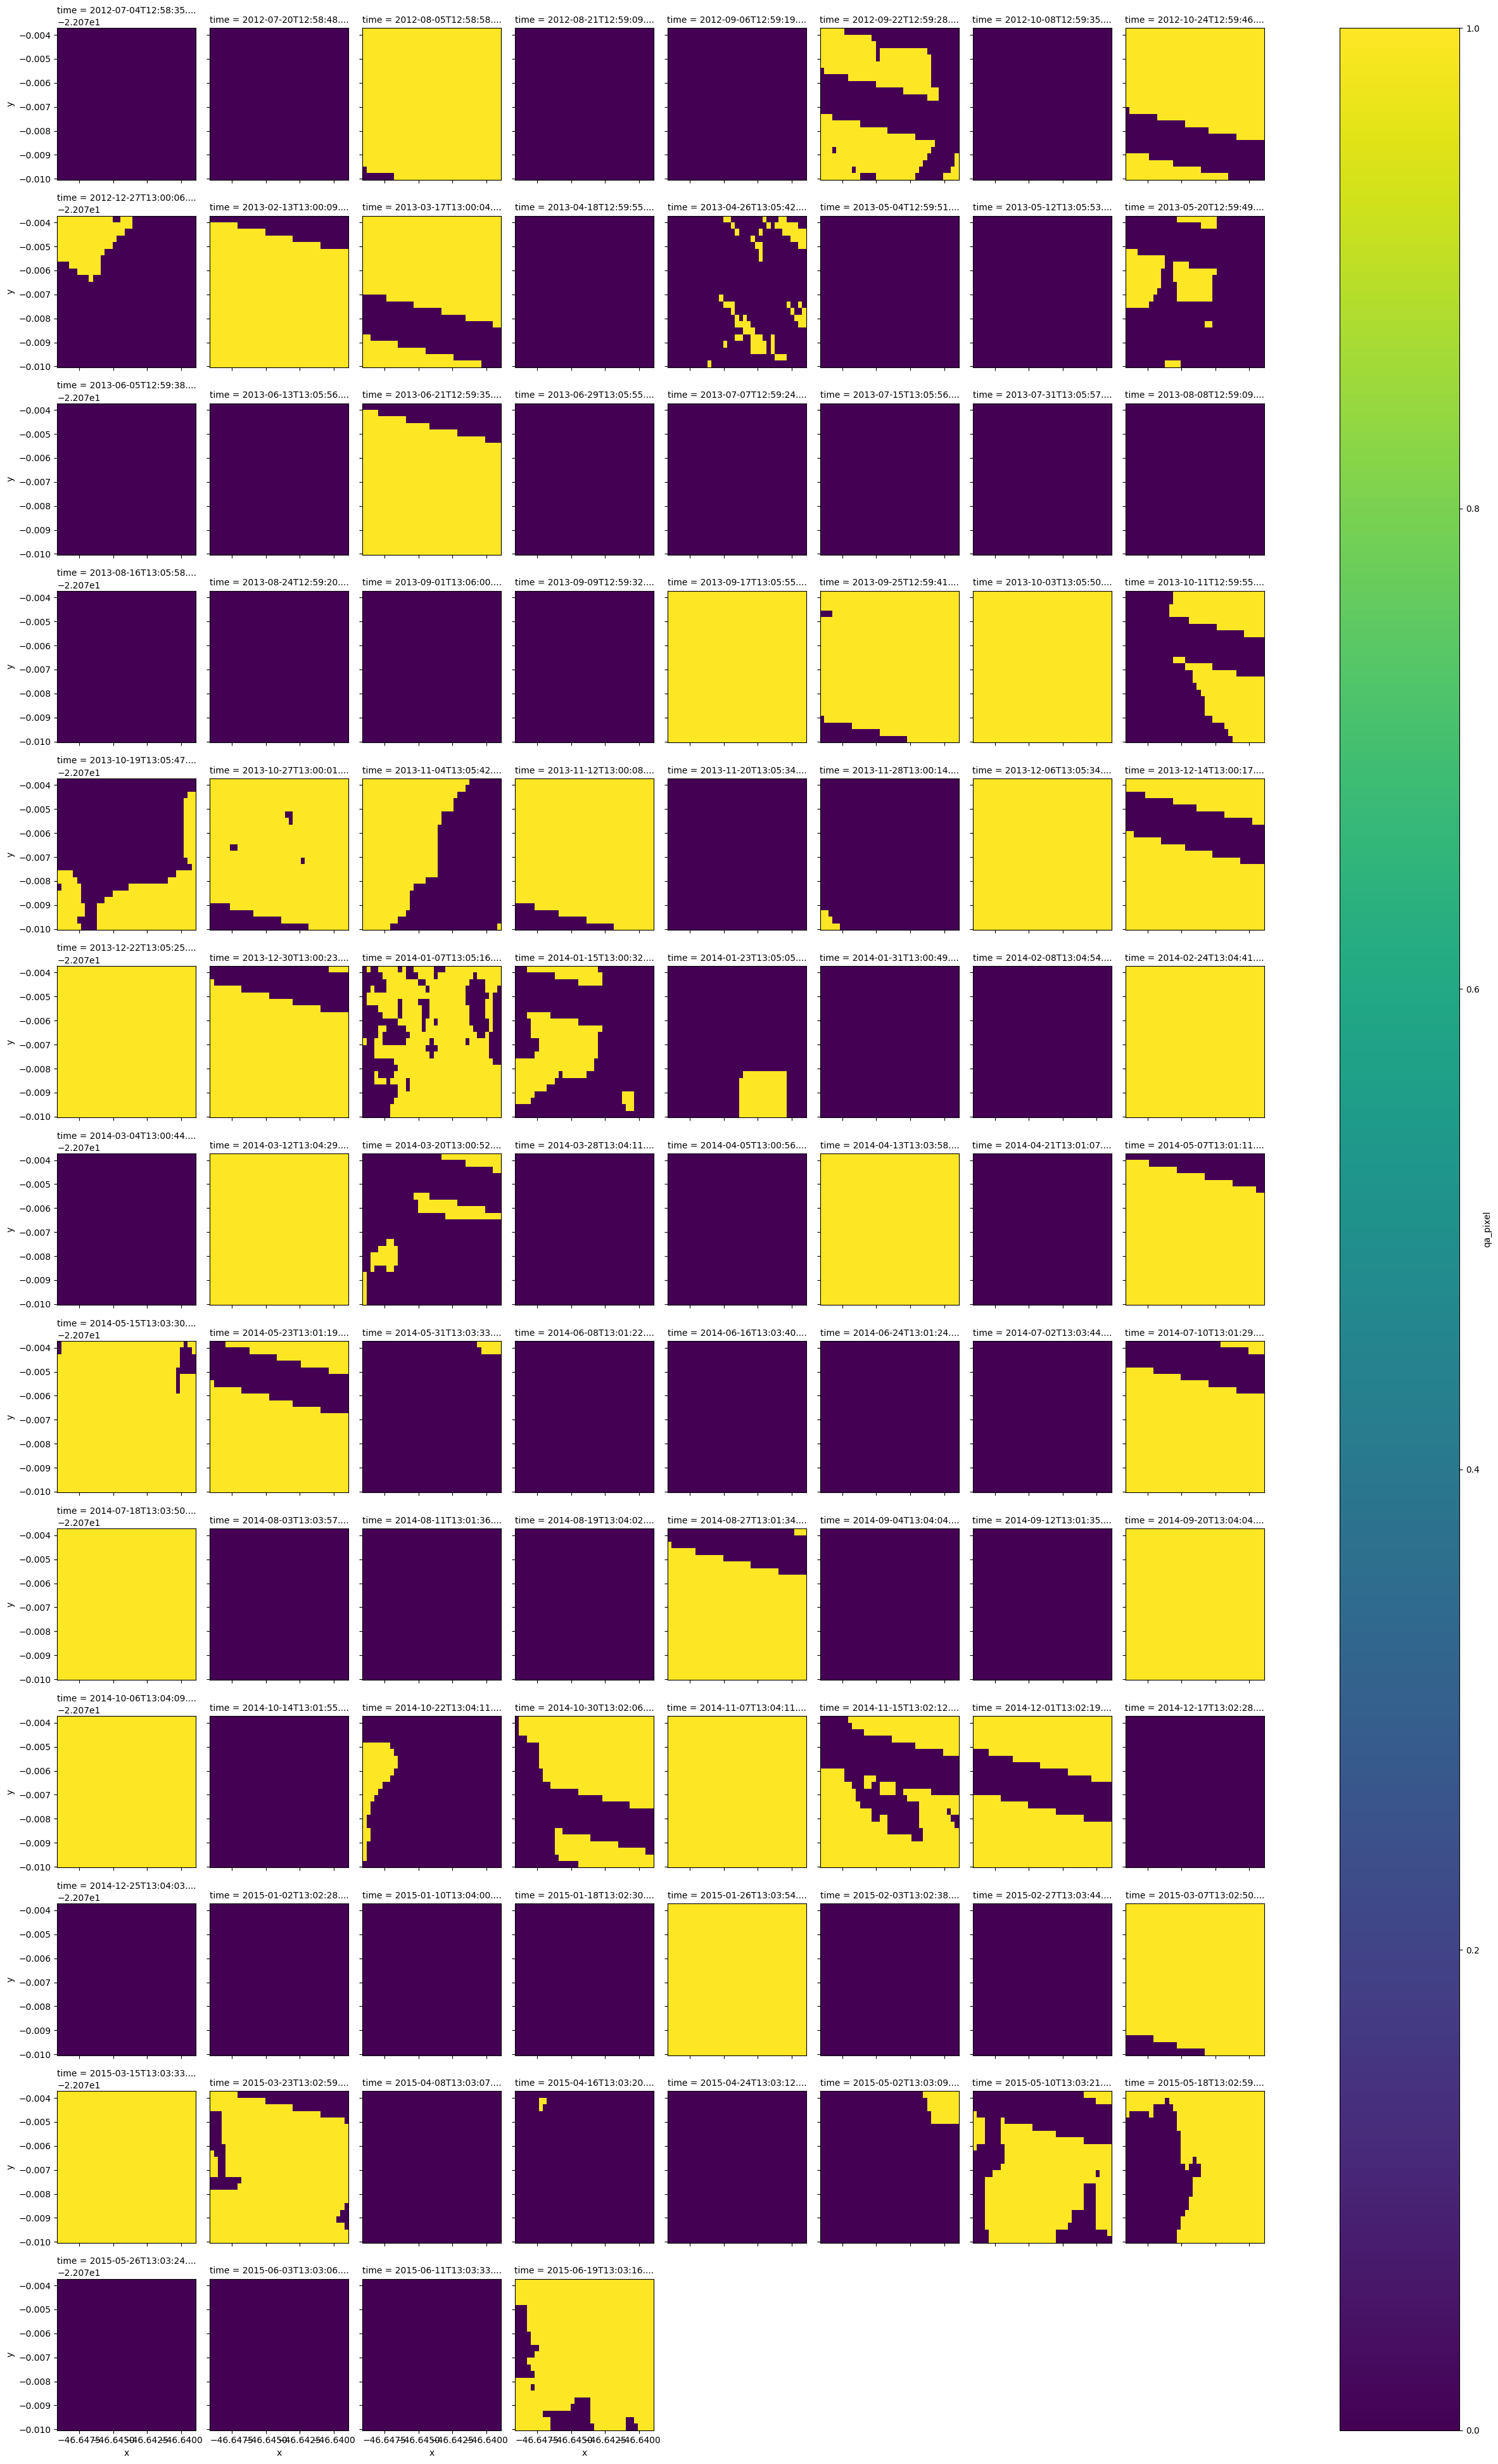

In [117]:
cloud_mask.plot(col='time', col_wrap = 8)

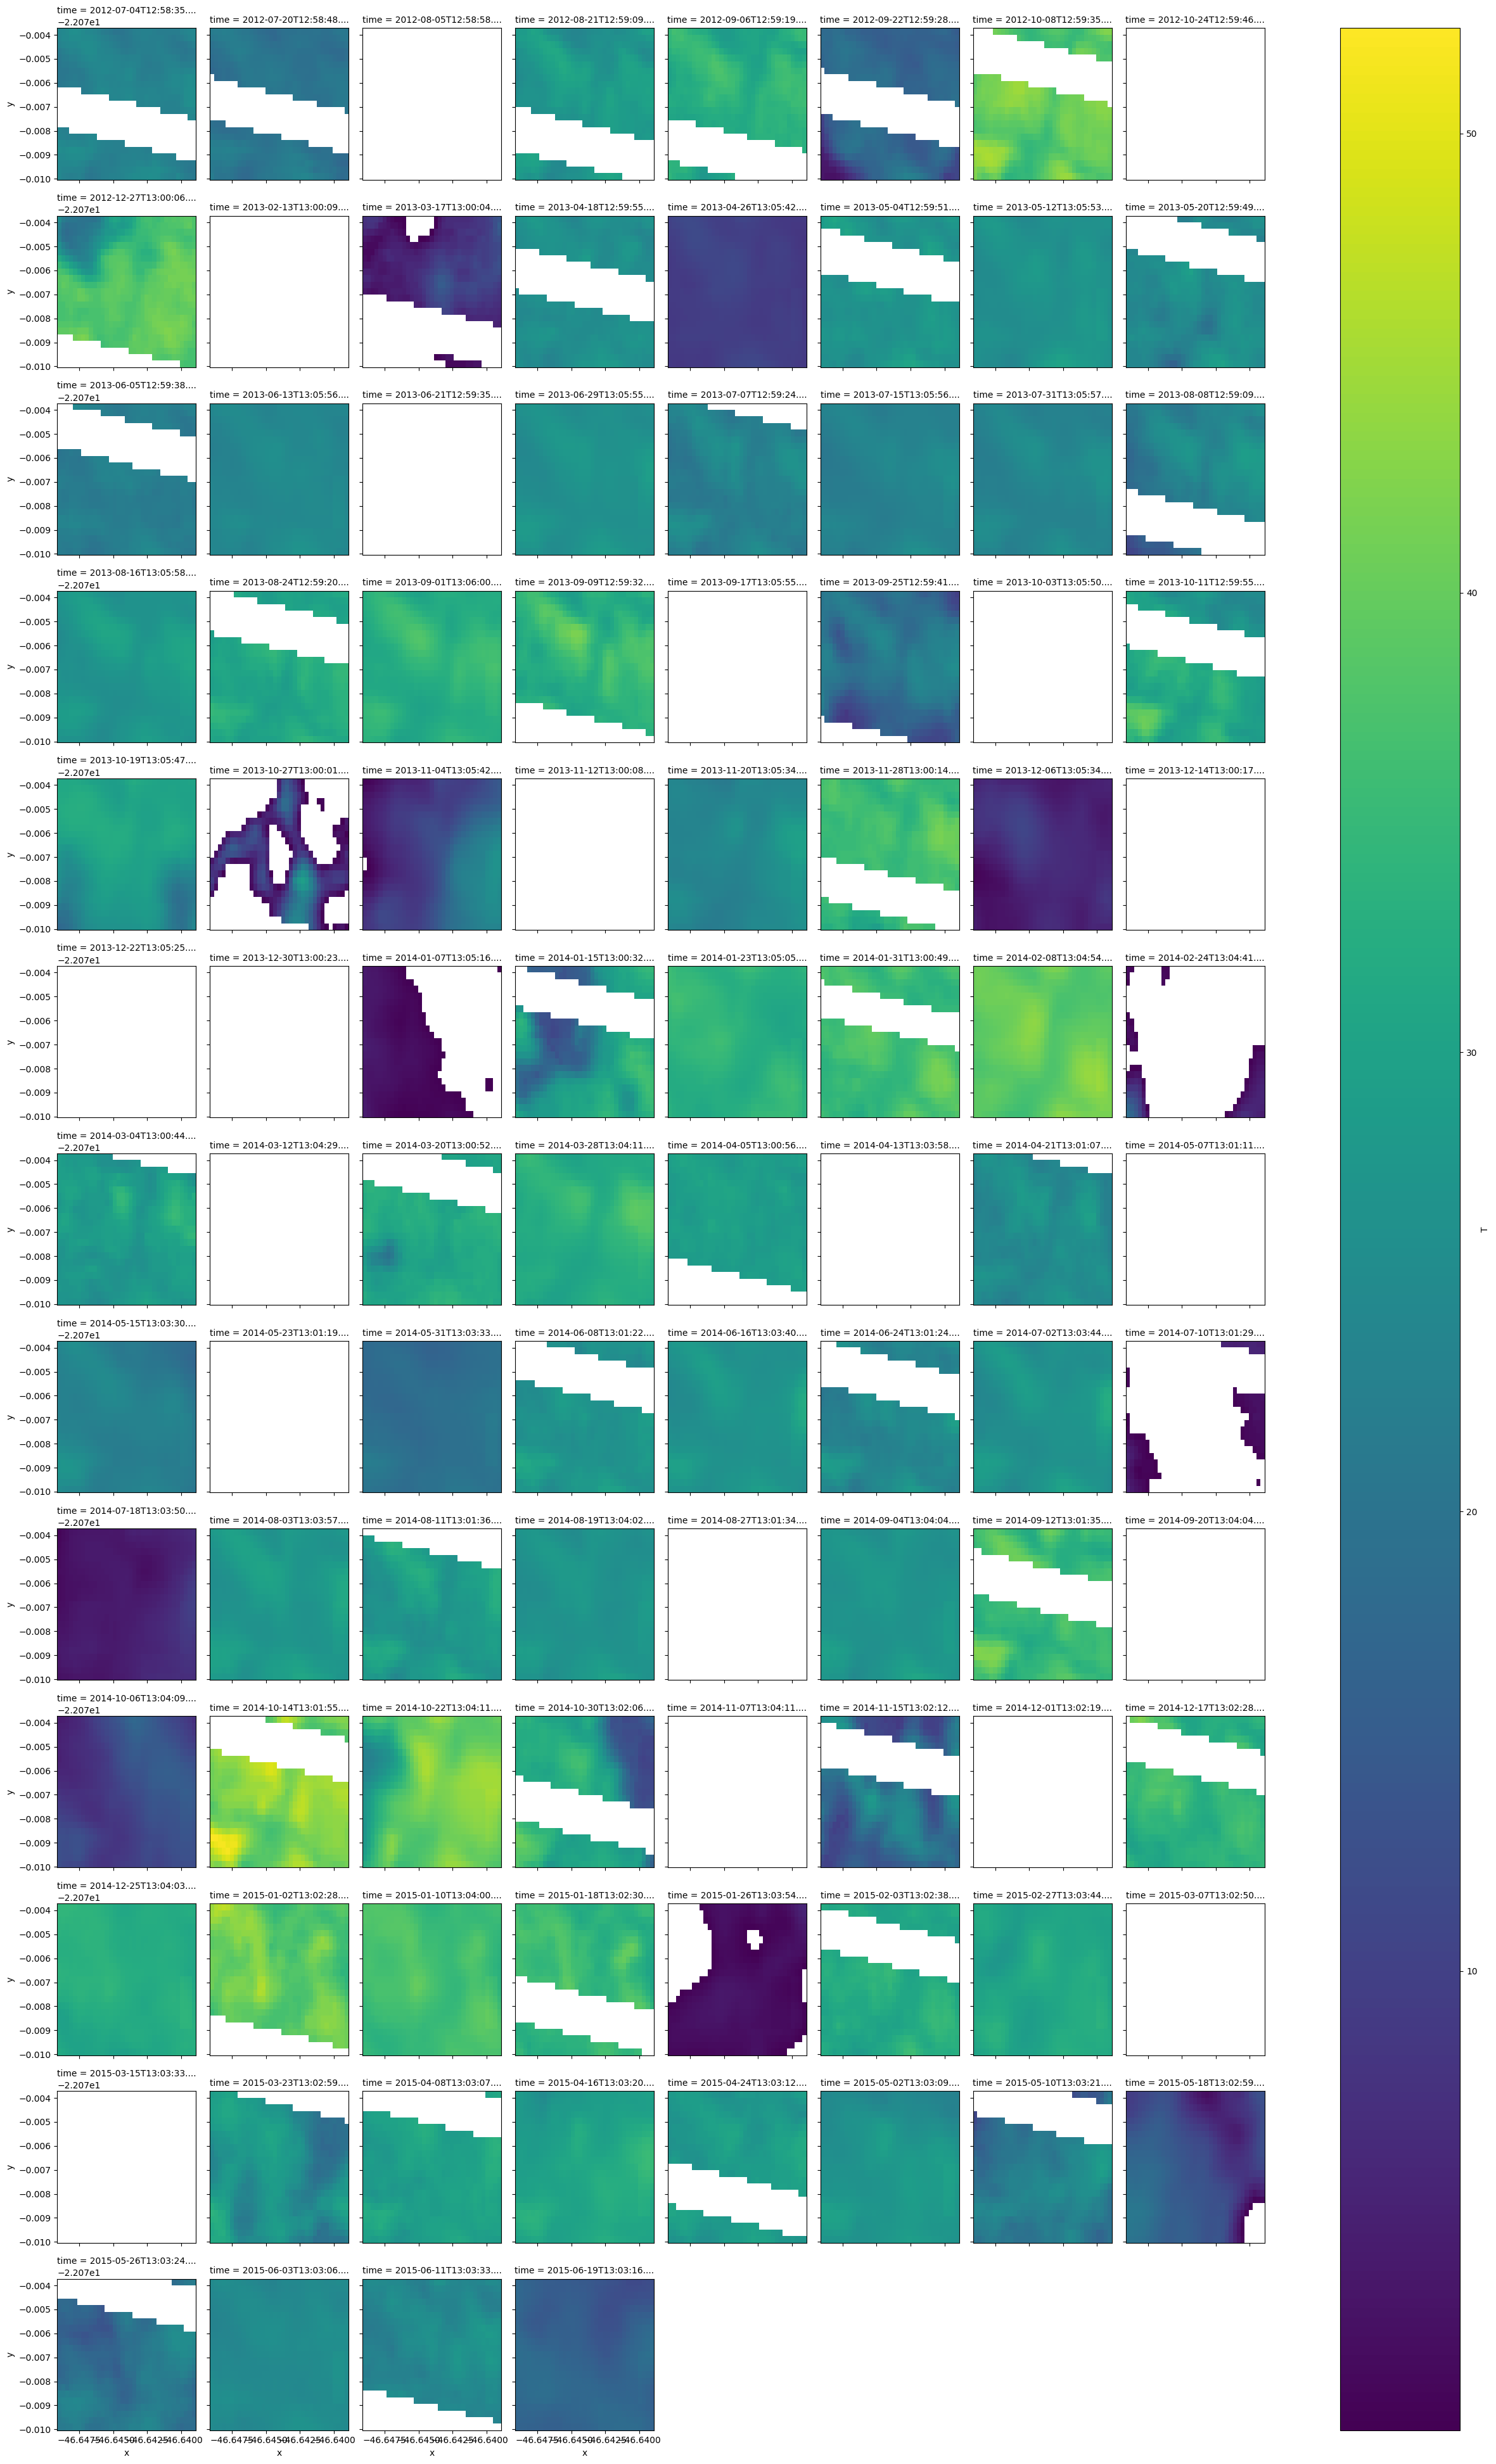

In [118]:
ds['T'].plot(col='time', col_wrap = 8)

### WORK On LAND SURFACE TEMPERATURE

##### the original LWIRs

In [164]:
ds = ds_.copy()

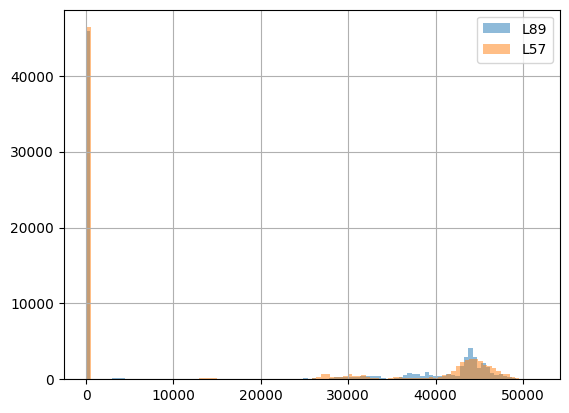

In [165]:
plt.hist(np.ravel(ds['lwir11'].values),bins=100, alpha=0.5, label='L89');
plt.hist(np.ravel(ds['lwir'].values),bins=100, alpha=0.5, label='L57');
plt.legend();plt.grid()

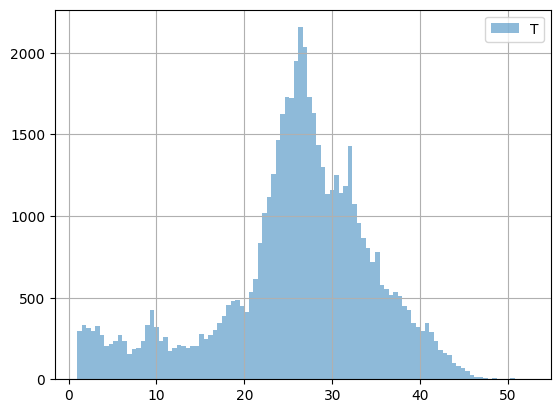

In [166]:
# SOMA, to Celcius and put nans
ds['T'] = (ds['lwir'] + ds['lwir11']) * 0.00341802 + 149 - 273.15

ds['T'] = ds['T'].astype('float32')
ds['T'] = xr.where(ds['T'] < 1, np.nan , ds['T'])

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

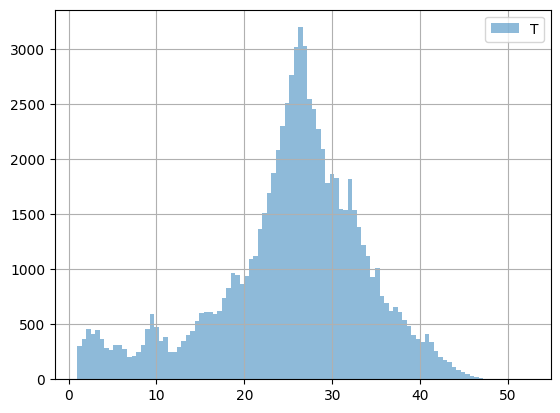

In [167]:
ds['T'] = ds['T'].chunk(dict(time=-1))
ds['T'] = ds['T'].interpolate_na(dim="time",
                method='linear',
                use_coordinate=True, 
            ) 

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

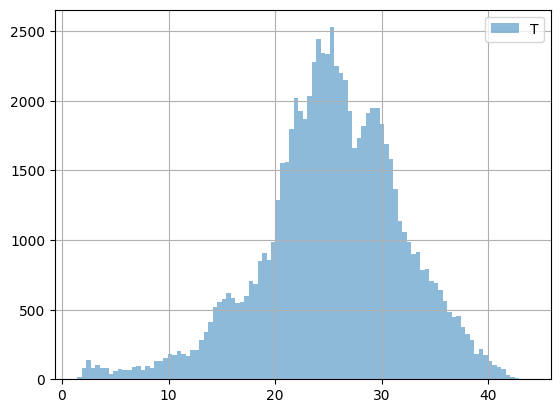

In [169]:
# rolling
w = 3
ds['T'] = ds['T'].rolling(time=w, center=True).mean(skipna=True)

plt.hist(np.ravel(ds['T'].values),bins=100, alpha=0.5, label='T');
plt.legend();plt.grid()

##### PREP 2 GO
com os cortes, interpolate_na e um leve smoothing, já tem cara de dado

In [170]:
ds2go = dropper(ds['T'], 'Landsat')
# REPROJECTION
print(f'reprojecting cube for {datetime_range}')
ds2go = ds2go.rio.write_crs('epsg:4326')
ds2go = ds2go.rio.reproject('EPSG:4326')
ds2go = ds2go.rename({'x': 'longitude','y': 'latitude'})
print('reprojecting... done')

ds2go.to_netcdf('/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/LST_interp_mm3.nc')

<<< landsat:correction dropped
<<< landsat:wrs_path dropped
<<< landsat:wrs_row dropped
<<< landsat:cloud_cover_land dropped
<<< landsat:collection_number dropped
<<< landsat:wrs_type dropped
<<< instruments dropped
--- raster:bands was not here
<<< eo:cloud_cover dropped
<<< accuracy:geometric_x_stddev dropped
no attribute spec to remove
reprojecting cube for 2012-06-20/2015-06-20
reprojecting... done
